# Goal : compute the alpha parameter as in https://arxiv.org/pdf/1909.02042.pdf

# $\alpha = 2.5 \frac{d logN(<m)}{dm}$

In [2]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import magnification_library
from scipy.optimize import curve_fit
import scipy.interpolate as itp
from scipy import stats
import matplotlib
import pandas as pd
matplotlib.rcParams.update({'font.size': 18})

In [3]:
def polyn(x, a, b, c):
    p = 0.5*a * x**2 + b * x + c
    return p 

In [4]:
def alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null):
    plt.figure()
    plt.hist(mag,bins=nbins, range=[mmin,mmax], cumulative=True, label='all')
    plt.yscale('log')
    plt.xlabel('i mag')
    plt.ylabel('cum. counts')
    
    plt.figure(figsize = (8,6))
    plt.subplot(211)
    plt.plot(falpha.x, falpha.y - 1 ,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red')
    plt.axvline(m_cut, color='blue')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')
    plt.ylabel('$\\alpha - 1$')
    plt.grid()
    
    plt.subplot(212)   
    plt.plot(falpha.x, snr,'k.')
    plt.axvspan(mag_lim, mag_lim+10, color='grey', alpha=0.5, lw=0)
    plt.axvline(m_cut_null, color='red',label='m_cut_null')
    plt.axvline(m_cut, color='blue',label='m_cut')
    plt.xlim(mmin,mag_lim+2.)
    plt.xlabel('i mag')  
    plt.ylabel('$|\\alpha - 1|\sqrt{N_s}$')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    return 

In [5]:
def alpha_derivation(mag, mmin, mmax, binsize, mag_lim, show_plots='False'):
    
    nbins = int((mmax - mmin)/binsize)
    mag_hist = stats.cumfreq(mag, numbins=nbins, defaultreallimits=[mmin,mmax])
    #mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
    
    N = mag_hist.cumcount[mag_hist.cumcount>0]
    #N = mag_hist[0][mag_hist[0]>0]
    mi = (np.linspace(mmin, mmax, nbins+1)[:-1] + binsize/2.)[mag_hist.cumcount>0]
    #mi = bin_center(mag_hist[1])[mag_hist[0]>0]
    logN = np.log10(N)
    
    step = int(0.5/binsize)
    param = np.zeros((3,mi.size - 2*step))
    dlogNdm = np.zeros((mi.size - 2*step))

    for j in range(mi.size - 2*step):
        i = j + step
        popt, pcov = curve_fit(polyn, mi[i-step:i+step], logN[i-step:i+step], maxfev=20000, p0=(0,0,0)) 
        param[:,j] = popt  
        dlogNdm[j] = popt[0]*mi[j]+popt[1]
        
    falpha = itp.interp1d(mi[step:-step], 2.5*dlogNdm)
    snr = (abs(falpha.y - 1)*np.sqrt(N[step:-step]))
    
    m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
    alpha_cut = float(falpha(m_cut))
    
    y0, tol = 1., 1e-4 
    xnew = np.linspace(falpha.x.min(), falpha.x.max(), int(1e6))
    ind = np.where(abs(falpha(xnew) - y0) < tol)[0]
    s = xnew[ind]
    
    if s[s<mag_lim].size> 0:
        m_cut_null = np.max(s[s<mag_lim])
    else :
        m_cut_null = -1.
    
    if show_plots:
        alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null)
    
    return m_cut, alpha_cut, m_cut_null, falpha, snr

In [6]:
sky_area_cosmoDC2 = 439.7898700906521

## - **LBG** *

In [7]:
gal_cat =  pd.read_hdf('cat_LBGp.h5', key='LBGp')

In [8]:
gal_cat.columns

Index(['mag_y_lsst', 'redshift', 'ra', 'mag_i_lsst', 'shear_1', 'mag_r_lsst',
       'mag_u_lsst', 'dec', 'shear_2', 'convergence', 'mag_g_lsst',
       'mag_z_lsst'],
      dtype='object')

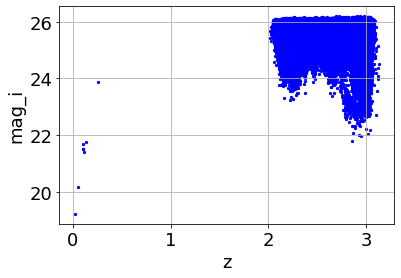

In [11]:
mu_wl = 1 + 2*gal_cat['convergence']
corr = 2.5*np.log10(mu_wl)

plt.scatter(gal_cat['redshift'],gal_cat['mag_i_lsst']-corr, s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

25.495 3.3111390852868805


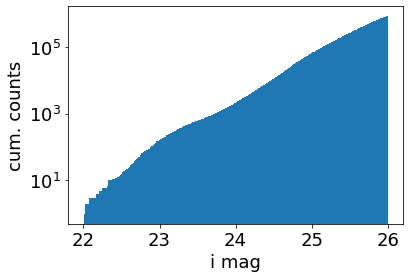

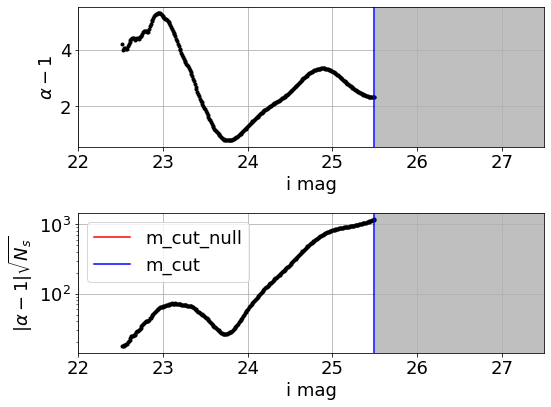

In [14]:
m_cut, alpha_cut, m_cut_null, falpha, snr = alpha_derivation(gal_cat['mag_i_lsst']-corr, 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut, alpha_cut)

25.495 3.320964657712193


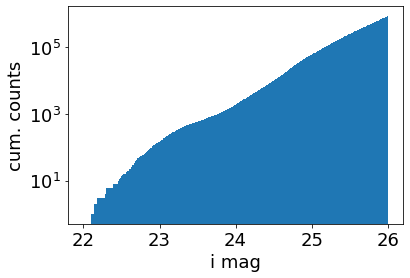

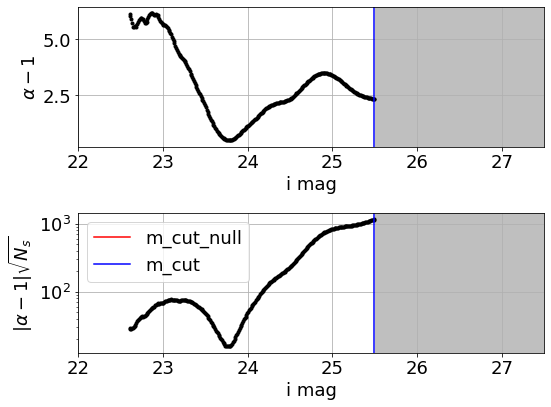

In [13]:
m_cut, alpha_cut, m_cut_null, falpha, snr = alpha_derivation(gal_cat['mag_i_lsst'], 22, 26, 0.01, 25.5, show_plots='True')
print(m_cut, alpha_cut)

In [20]:
snr[-1]

1162.9052076553894

## - **LBG** **

In [21]:
gal_cat =  pd.read_hdf('cat_LBGpp.h5', key='LBGpp')

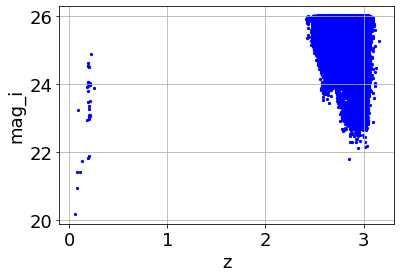

In [22]:
plt.scatter(gal_cat['redshift'],gal_cat['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

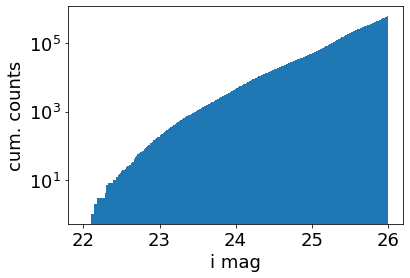

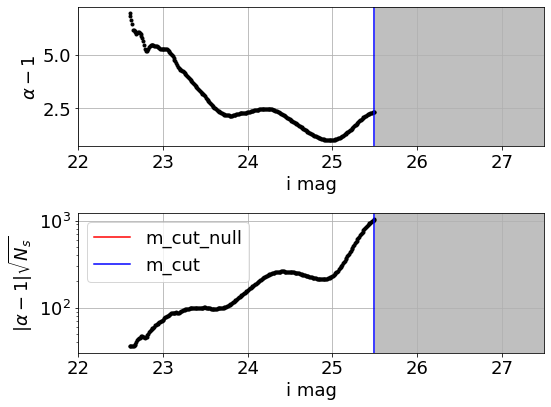

In [23]:
m_cut, alpha_cut, m_cut_null, falpha, snr = alpha_derivation(gal_cat['mag_i_lsst'], 22, 26, 0.01, 25.5, show_plots='True')

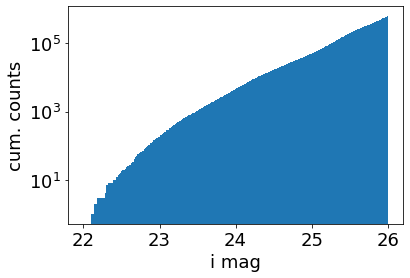

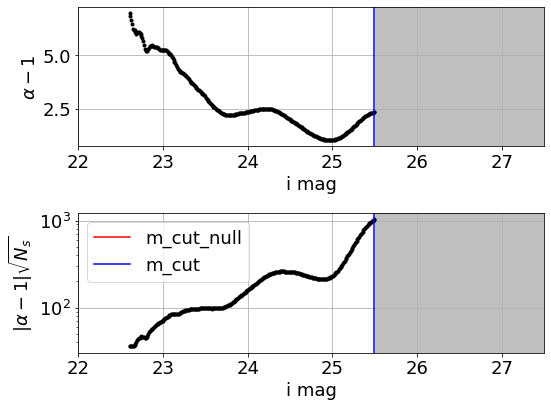

In [24]:
m_cut1, alpha_cut1, m_cut_null1, falpha1, snr1 = alpha_derivation(gal_cat['mag_i_lsst'][gal_cat['redshift']>1], 22, 26, 0.01, 25.5, show_plots='True')

In [25]:
print (m_cut, alpha_cut, snr[-1])

25.495 3.322805490732099 1030.3913841399558


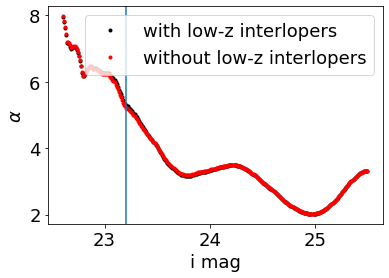

In [69]:
plt.plot(falpha.x, falpha.y,'k.', label='with low-z interlopers')
plt.plot(falpha1.x, falpha1.y,'r.', label='without low-z interlopers')

plt.axvline(23.2)

plt.xlabel('i mag')
plt.ylabel('$\\alpha$')
plt.legend()

In [70]:
m_cut, alpha_cut, m_cut_null

(25.495, 3.322805490732099, -1.0)

In [71]:
m_cut1, alpha_cut1, m_cut_null1

(25.495, 3.3238981295276693, -1.0)

In [72]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)
source_dens = len(gal_cat['mag_i_lsst'][gal_cat['mag_i_lsst']<m_cut1])/(sky_area_cosmoDC2*u.deg*u.deg)
print( source_dens, source_dens.value*conv)

441.67911361842164 1 / deg2 0.12268864267178377 1 / arcmin2


## = > No impact from the few low-z interlopers if the histogram starts at the brightest magnitude of the high z sample. 

## - **U-drop** *

In [73]:
gal_cat =  pd.read_hdf('cat_Udropp.h5')

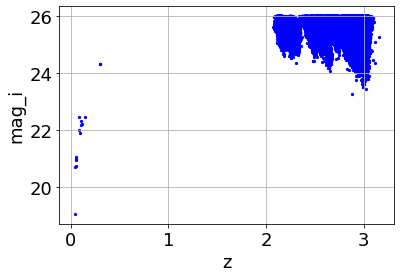

In [74]:
plt.scatter(gal_cat['redshift'],gal_cat['mag_i_lsst'], s=5, color='blue', label='LBG*')
plt.xlabel('z')
plt.ylabel('mag_i')
plt.grid()

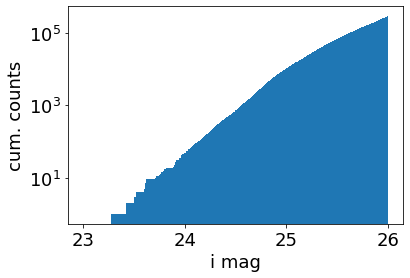

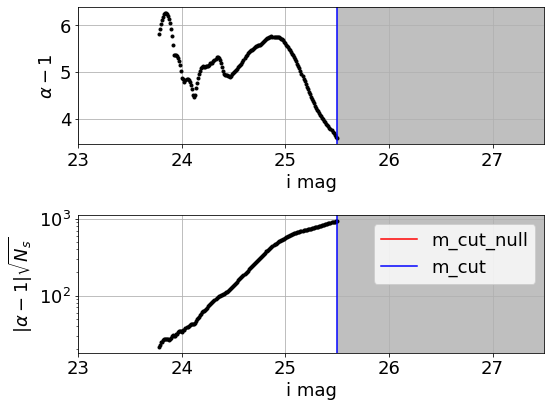

In [75]:
m_cut, alpha_cut, m_cut_null, falpha, snr  = alpha_derivation(gal_cat['mag_i_lsst'], 23, 26, 0.01, 25.5, show_plots='True')

In [76]:
m_cut, alpha_cut, m_cut_null

(25.495, 4.582466881801874, -1.0)

In [77]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)
source_dens = len(gal_cat['mag_i_lsst'][gal_cat['mag_i_lsst']<m_cut])/(sky_area_cosmoDC2*u.deg*u.deg)
print( source_dens, source_dens.value*conv)

149.73969270012014 1 / deg2 0.0415943590833667 1 / arcmin2


## = > For LBG* and U-drop* samples their is no null-count slope in the desired magnitude range. 

In [1]:
#key , m_cut, alpha_cut, m_cut_null

source_sample_properties = np.array([['LBGp', 25.495, 4.582466881801874, -1.0]
,['LBGpp', 25.495, 3.322805490732099, -1.0]
,['Udropp', 25.495, 4.582466881801874, -1.0]],dtype=object)


np.save("source_sample_properties.npy", source_sample_properties)

NameError: name 'np' is not defined